In [1]:
# !pip install torch_geometric
# !pip install rdkit-pypi
# !pip install py3Dmol

<a target="_blank" href="https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/w2024/Course_Notes/Week%2012/intro_GNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import tqdm
import numpy as np
import pandas as pd
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
# from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader

import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300, 300

## How do we represent molecules as graphs? ##

Today's tutorial is based on the following online tutorial,<br>
[How to turn a SMILES string into a molecular graph for Pytorch Geometric](https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/)

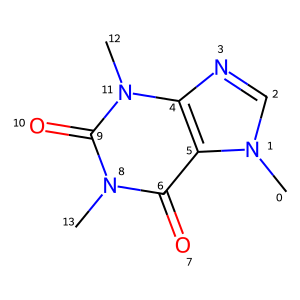

In [3]:
caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = AllChem.MolFromSmiles(caff_sm)
m

Molecules can be considered as graphs where,
* atoms are the **nodes**
* bonds are the **edges**

Depending on the type of atom and bond, is the information that we will use to represent the graph. 

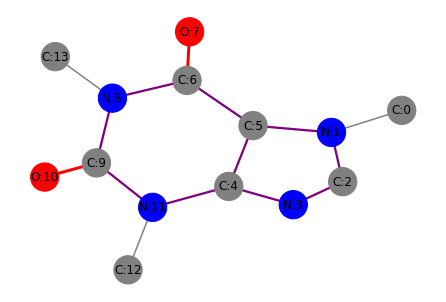

In [4]:
# define the function for coverting rdkit object to networkx object -----------
def molecular_graph(mol):
    bonds_color_map = {'SINGLE': 'grey',
                       'DOUBLE': 'red',
                       'TRIPLE': 'blue',
                       'AROMATIC': 'purple',
                       }
    # core function to construct a molecular graph
    def mol_to_nx(mol):
        G = nx.Graph()

        for atom in mol.GetAtoms():

            G.add_node(atom.GetIdx(),
                       atomic_num=atom.GetAtomicNum(),
                       is_aromatic=atom.GetIsAromatic(),
                       atom_symbol=atom.GetSymbol())

        for bond in mol.GetBonds():
            bt = bond.GetBondType()
            bt_float = bond.GetBondTypeAsDouble()
            G.add_edge(bond.GetBeginAtomIdx(),
                       bond.GetEndAtomIdx(),
                       bond_type=bt,
                       color=bonds_color_map[str(bt)],
                       weight=1.5*bt_float)

        return G

    # conver rdkit object to networkx object
    mol_nx = mol_to_nx(mol)

    mol_atom = nx.get_node_attributes(mol_nx, 'atom_symbol')
    mol_atom_w_indx = mol_atom.copy()
    for i, k in enumerate(mol_atom_w_indx):
        mol_atom_w_indx[k] = '%s:%s' % (mol_atom[i], i)

    color_map = {'C': 'grey',
                 'O': 'red',
                 'N': 'blue',
                 'H': 'white',
                 }

    mol_colors = []
    for idx in mol_nx.nodes():
        if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
            mol_colors.append(
                color_map[mol_nx.nodes[idx]['atom_symbol']])
        else:
            mol_colors.append('gray')

    edge_weight = []
    bond_types_str = ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']

    edges = mol_nx.edges()
    weights = [mol_nx[u][v]['weight'] for u, v in edges]
    mol_edge_colors = [mol_nx[u][v]['color'] for u, v in edges]
    nx.draw(mol_nx,
            labels=mol_atom_w_indx,
            with_labels=True,
            node_color=mol_colors,
            width=weights,
            edge_color=mol_edge_colors,
            node_size=800)

    plt.show()


caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = AllChem.MolFromSmiles(caff_sm)
# mol_wH = Chem.rdmolops.AddHs(mol)
molecular_graph(mol)

In [5]:
# lets print the adjacency matrix of Caffeine
m = Chem.rdmolops.GetAdjacencyMatrix(mol)
print(m)
atoms = [a.GetSymbol() for a in mol.GetAtoms()]
print(atoms)

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 1 0 0]
 [0 1 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
['C', 'N', 'C', 'N', 'C', 'C', 'C', 'O', 'N', 'C', 'O', 'N', 'C', 'C']


## Graph features ##

Original RDKit tutorial on Graphs, [link](https://www.rdkit.org/docs/GettingStartedInPython.html#looping-over-atoms-and-bonds)

In [6]:
# this function is not perfect, but for today's tutorial it works
def one_hot_encoding(x,dictionary):
    encoding = []
    for di in dictionary:
        if x == di:
            encoding.append(1)
        else:
            encoding.append(0)
    return encoding

### Node Features ###

The ```atom``` class in ```RDKit``` contains all the necesarry information of each atom that conforms a molecule, [link](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom). <br>
1. ```Atom.GetAtomicNum()```
2. ```Atom.GetSymbol()```
3. ```Atom.GetHybridization()```
4. ```Atom.GetIsAromatic()```
5. ```Atom.GetIsotope()```
6. ```Atom.GetNeighbors()```
7. ```Atom.IsInRing()```
8. ```Atom.GetChiralTag()```

All these additional information can be used in the feature representation of each node. 

It worth mentioning that, the hand crafting of the feature representation is "case-specific".

In [7]:
def get_nodes_features(mol):
    dictionary_atoms = ['C', 'O','N','H','F']
    
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    edges_features = []
    for ai in atoms:#iterate over the atoms
        ai_encoding = one_hot_encoding(ai, dictionary_atoms)
        edges_features.append(ai_encoding)

    return np.array(edges_features)

print(get_nodes_features(mol))

[[1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


### Edges features ###

RDKit also allows you to get the specific information between each bond of the molecule. 
1. bond type: ```bond.GetBondType()```
2. conjugate bonds: ```bond.GetIsConjugate()```
3. aromatic bond in ring: ```bond.IsInRing()```



In [8]:
def get_edges_features(mol):
    bond_dictionary = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                    Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bonds_features = []
    for bond in mol.GetBonds():
        bi = bond.GetBondType()
        bi = one_hot_encoding(bi, bond_dictionary)
        
        bond_is_conj_enc = [int(bond.GetIsConjugated())]
        bond_is_in_ring_enc = [int(bond.IsInRing())]
        
        bi = bi + bond_is_conj_enc + bond_is_in_ring_enc
        bonds_features.append(bi)
        
    return np.array(bonds_features)

print(get_edges_features(mol))

[[1 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 1 0 0 1 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 1 0 0 1 0]
 [0 0 0 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]]


In [9]:
def get_edge_features(bond):
    bond_dictionary = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                       Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_features = []

    bi = bond.GetBondType()
    bi = one_hot_encoding(bi, bond_dictionary)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bi = bi + bond_is_conj_enc + bond_is_in_ring_enc
    bond_features.append(bi)

    return np.array(bond_features)

print(get_edges_features(mol))

[[1 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 1 0 0 1 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 1 0 0 1 0]
 [0 0 0 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]]


In [110]:
def get_single_graph_info(smiles,y):
    mol = Chem.MolFromSmiles(smiles)
    # nodes
    X_nodes = get_nodes_features(mol)
    X_nodes = torch.tensor(X_nodes, dtype=torch.float)

    # edges
    # X_edges = get_edges_features(mol)
    # X_edges = torch.tensor(X_edges, dtype=torch.float)
    
    # adjacency matrix
    Am = Chem.rdmolops.GetAdjacencyMatrix(mol)
    (rows, cols) = np.nonzero(Am)
    
    # construct edge feature array EF of shape (n_edges, n_edge_features)
    n_edges = 2*mol.GetNumBonds()
    n_edge_features = get_edge_features(mol.GetBonds()[0]).shape[-1]
    
    EF = np.zeros((n_edges, n_edge_features))
    for (k, (i,j)) in enumerate(zip(rows, cols)):
        
        EF[k] = get_edge_features(mol.GetBondBetweenAtoms(int(i),int(j)))
    
    EF = torch.tensor(EF, dtype = torch.float)


    torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
    torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
    E = torch.stack([torch_rows, torch_cols], dim = 0)

    y = torch.tensor(y,dtype=torch.float)
    
    x_molecule = (X_nodes, torch.rand(X_nodes.shape[0], 3))

    d = Data(x=x_molecule,edge_index=E, edge_attr=EF, y=y)
    return d 
print(get_single_graph_info(caff_sm,0.))

Data(x=[2], edge_index=[2, 30], edge_attr=[30, 6], y=0.0)


## Data loading ##

Let's load the data!

We are going to use the **QM9** dataset, [link](http://quantum-machine.org/datasets/).


<bound method DataFrame.info of                     smiles     gap
27878      Cc1cc(cc(n1)O)N  0.2233
69114     CC12CC1(OCC2)C=O  0.2127
5000         Cc1c(=O)occn1  0.1738
41267  C1OC23CC4CC(C12)C34  0.3038
1820        C1C(=O)C=CC1=O  0.1555
...                    ...     ...
37547   C1N=CN2C3C4NC3C124  0.2321
17262     CC12CN(C1)C21CC1  0.3165
64218      CC1(O)COC1C1CC1  0.3070
21196           CNc1ncnn1C  0.2449
71063     CC12NC3=NCC1C23O  0.1614

[20000 rows x 2 columns]>
Training data  10000
Test data  10000


Text(0.5, 0, 'gap')

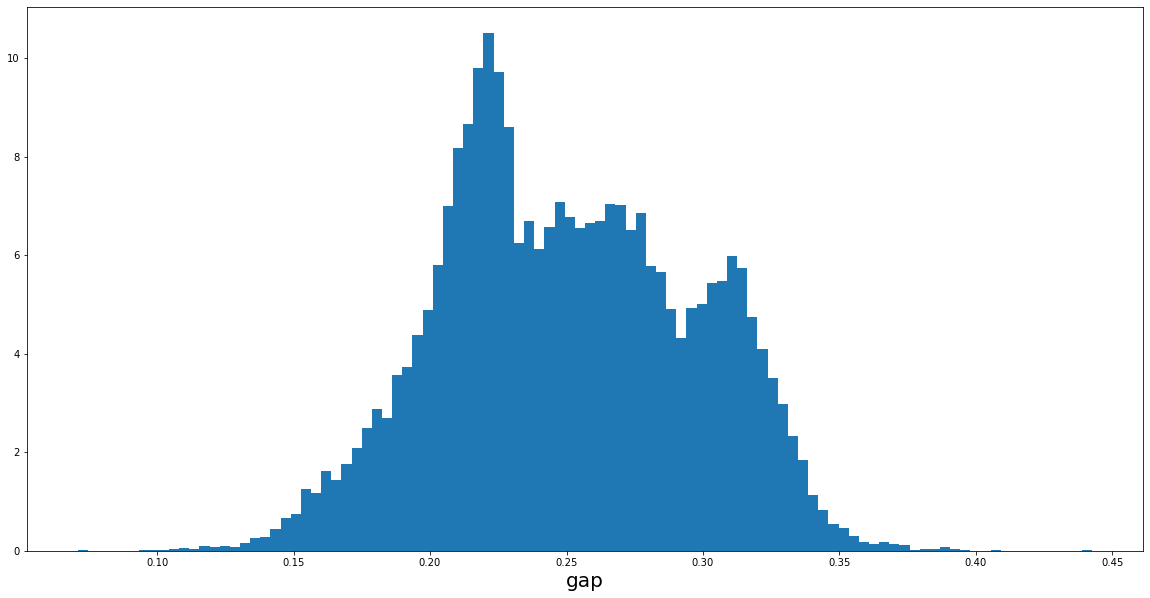

In [116]:
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/qm9.csv"
data = pd.read_csv(data_url)
data = data.sample(20000)
data = data[['smiles','gap']]
print(data.info)
y_all = data['gap'].to_numpy()

# Splitting DataFrame into training and test sets
train_df, test_df = train_test_split(data, test_size=0.5, random_state=42)
print('Training data ', len(train_df['smiles'].to_list()))
print('Test data ', len(test_df['smiles'].to_list()))

# x_smiles_all = data['smiles'].to_list()
# y_all = data['gap'].to_numpy()
# print(x_smiles_all[:10])

plt.figure(figsize=(20,10))
plt.hist(y_all,bins=100,density=True)
plt.xlabel('gap',fontsize=20)

In [117]:
smiles_tr = train_df['smiles'].to_list()
y_tr = train_df['gap'].to_numpy()
data_list_tr = [get_single_graph_info(si,yi) for si,yi in zip(smiles_tr,y_tr)]
dataloader_tr = DataLoader(data_list_tr,batch_size=128,shuffle=True)

smiles_tst = test_df['smiles'].to_list()
y_tst = test_df['gap'].to_numpy()
data_list_tst = [get_single_graph_info(si, yi) for si,yi in zip(smiles_tst,y_tst)]
dataloader_tst = DataLoader(data_list_tst, batch_size=64)

/usr/local/anaconda3/envs/chem4pb3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Graph Neural Network ##

In [118]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, SAGPooling, global_max_pool

class MoleculeGNN(torch.nn.Module):
    def __init__(self, num_node_features, edge_index):
        super(MoleculeGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)
        # self.conv2 = GCNConv(128, 128)
        # self.conv3 = GCNConv(128, 128)
        # self.fc1 = torch.nn.Linear(128, 128)
        self.fc = torch.nn.Linear(128, 1)
        self.act = torch.nn.LeakyReLU(0.1)
        
        self.pool1 = SAGPooling(128, min_score=0.001, GNN=GCNConv)
        self.pool2 = SAGPooling(128, min_score=0.001, GNN=GCNConv)

    def forward(self, data):
        (x,x_geom), edge_index, batch = data.x, data.edge_index, data.batch
        # three-layers of GCN
        x = self.act(self.conv1(x, edge_index))
        # x, edge_index, _, batch, perm, score = self.pool1(
        #     x, edge_index, None, batch)
        # x = F.relu(self.conv2(x, edge_index))
        # x, edge_index, _, batch, perm, score = self.pool2(
        #     x, edge_index, None, batch)
        # x = F.relu(self.conv3(x, edge_index))

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layer for classification or regression
        # x = self.fc1(x)
        y = self.fc(x)
        return y

In [119]:
def train(model, trainloader, training_epochs=60):
    # Define the loss function and optimizer
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    iterator = tqdm.notebook.tqdm(range(training_epochs))
    model.train()
    # Run the training loop (epochs)
    loss_trajectory = []
    for epoch in iterator:

        # Set current loss value
        current_loss = []
        for i, batch in enumerate(trainloader, 0):
            # inputs, targets = data

            outputs = model(batch)

            optimizer.zero_grad()

            y_true = torch.tensor(batch.y, dtype=torch.float32)
            loss = loss_function(outputs[:,0], y_true)
            loss.backward()
            optimizer.step()

            # Print statistics
            # current_loss += loss.item()
            current_loss.append(loss.item())
        # print('Epoch %s: %.4f +- %.4f'%(epoch,np.array(current_loss).mean(),np.array(current_loss).std()))
        iterator.set_postfix(loss=torch.tensor(current_loss).mean())
        loss_trajectory.append(current_loss)
        # Process is complete.
    return loss_trajectory

In [120]:
# Example usage

unrelated_smiles = "O=O"
unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
unrelated_node_features = get_nodes_features(unrelated_mol)
n_node_features = unrelated_node_features.shape[-1]
d = get_single_graph_info(unrelated_smiles,0.)


gnn_model = MoleculeGNN(num_node_features=n_node_features,edge_index=d.edge_index)

loss_trajectory = train(gnn_model, dataloader_tr,100)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/chem4pb3/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'x', 'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
/var/folders/x7/dwvwf5c92p71ds8swvmz8rlh0000gn/T/ipykernel_60095/1109832239.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(batch.y, dtype=torch.float32)


(100, 79) (100,) (100,)


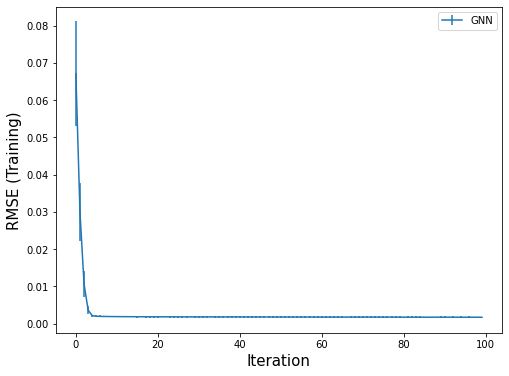

In [121]:
loss_trajectory = np.array(loss_trajectory)
mean_loss_itr = np.mean(loss_trajectory, axis=1)
std_loss_itr = np.std(loss_trajectory, axis=1)
print(loss_trajectory.shape, mean_loss_itr.shape, std_loss_itr.shape)

# figure
fig, ax = plt.subplots(figsize=[8, 6])
ax.errorbar(
    np.arange(loss_trajectory.shape[0]), mean_loss_itr, yerr=std_loss_itr, label='GNN')
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('RMSE (Training)', fontsize=15)

ax.legend()
plt.show()

## Prediction ##

In [124]:
gnn_model.eval()  # Set the model to evaluation mode

predictions = []  # List to store predictions

y_true = []
with torch.no_grad():  # No need to track gradients
    for batch in dataloader_tr:
        # Forward pass to get outputs
        output = gnn_model(batch)
        
        # Or directly append the raw output if you will process it later
        predictions.append(output.cpu().numpy())
        y_true.append(batch.y.cpu().numpy())

# Concatenate all batch predictions
predictions = np.concatenate(predictions, axis=0)
y_true = np.concatenate(y_true,axis=0)

/usr/local/anaconda3/envs/chem4pb3/lib/python3.9/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'x', 'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Text(0, 0.5, 'True')

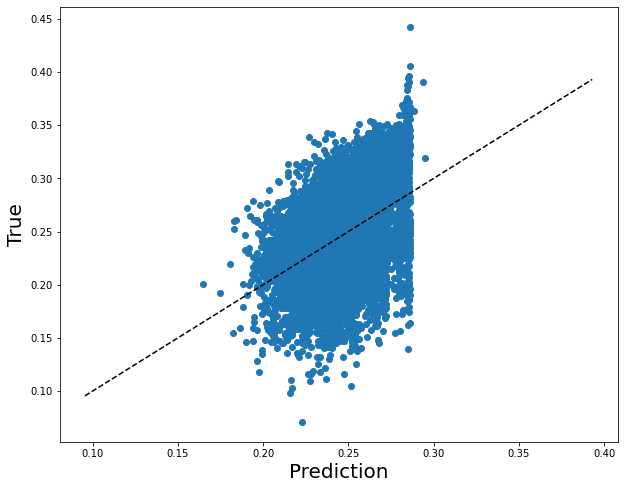

In [125]:
plt.figure(figsize=(10,8))
plt.scatter(predictions.ravel(), y_true)

min_val = min(min(predictions), min(test_df['gap'].to_numpy()))
max_val = max(max(predictions), max(test_df['gap'].to_numpy()))
plt.plot([min_val, max_val], [min_val, max_val],
         color='k', linestyle='--', label='Ideal')


plt.xlabel('Prediction', fontsize=20)
plt.ylabel('True',fontsize=20)